In [1]:
# import jax
# import jax.numpy as jnp

# jax.config.update("jax_compilation_cache_dir", "../jax-caches")
# jax.config.update("jax_persistent_cache_min_entry_size_bytes", -1)
# jax.config.update("jax_persistent_cache_min_compile_time_secs", 0)

In [2]:
import sys
import os

sys.path.insert(0, os.path.abspath("."))
sys.path.append(os.path.abspath("../"))

# os.environ["XLA_PYTHON_CLIENT_MEM_FRACTION"] = "0.25"
# os.environ["XLA_PYTHON_CLIENT_ALLOCATOR"] = "platform"
# from desc import set_device
# set_device("gpu")

In [3]:
# from desc import set_device, _set_cpu_count

# num_device = 2
# _set_cpu_count(num_device)
# set_device("cpu", num_device=num_device)

In [4]:
import numpy as np
np.set_printoptions(linewidth=np.inf, precision=4, suppress=True, threshold=sys.maxsize)
import matplotlib.pyplot as plt
%matplotlib inline
import plotly.graph_objects as go
import functools
import scipy

In [5]:
import desc

from desc.basis import *
from desc.backend import *
from desc.compute import *
from desc.coils import *
from desc.equilibrium import *
from desc.examples import *
from desc.grid import *
from desc.geometry import *

from desc.objectives import *
from desc.objectives.objective_funs import *
from desc.objectives.getters import *
from desc.objectives.normalization import compute_scaling_factors
from desc.objectives.utils import *
from desc.optimize._constraint_wrappers import *

from desc.transform import Transform
from desc.plotting import *
from desc.optimize import *
from desc.perturbations import *
from desc.profiles import *
from desc.compat import *
from desc.utils import *
from desc.magnetic_fields import *

from desc.__main__ import main
from desc.vmec_utils import vmec_boundary_subspace
from desc.input_reader import InputReader
from desc.continuation import solve_continuation_automatic
from desc.compute.data_index import register_compute_fun
from desc.optimize.utils import solve_triangular_regularized

print_backend_info()

DESC version=0.14.2+234.g4740f9333.
Using JAX backend: jax version=0.6.2, jaxlib version=0.6.2, dtype=float64.
Using device: CPU, with 7.56 GB available memory.


In [6]:
surf = FourierRZToroidalSurface(
    R_lmn=[1, 0.166, 0.1],
    Z_lmn=[-0.166, -0.1],
    modes_R=[[0, 0], [1, 0], [0, 1]],
    modes_Z=[[-1, 0], [0, -1]],
    NFP=2,
)
# create initial equilibrium. Psi chosen to give B ~ 1 T. Could also give profiles here,
# default is zero pressure and zero current
eq = Equilibrium(M=8, N=8, Psi=0.087, surface=surf)

In [7]:
obj = ObjectiveFunction(ForceBalance(eq))
cons = get_fixed_boundary_constraints(eq)
cons = maybe_add_self_consistency(eq, cons)
cons = ObjectiveFunction(cons)
obj = LinearConstraintProjection(obj, cons)
obj.build()

Building objective: force
Precomputing transforms
Building objective: lcfs R
Building objective: lcfs Z
Building objective: fixed Psi
Building objective: fixed pressure
Building objective: fixed current
Building objective: fixed sheet current
Building objective: self_consistency R
Building objective: self_consistency Z
Building objective: lambda gauge
Building objective: axis R self consistency
Building objective: axis Z self consistency


In [8]:
J = obj.jac_scaled_error(obj.x(eq))

In [9]:
cond = np.linalg.cond(J)
print(f"Condition number of the Jacobian: {cond:.2e}")

Condition number of the Jacobian: 3.45e+07


In [10]:
from desc.optimize.utils import compute_jac_scale
scale, scale_inv = compute_jac_scale(J)
max(scale), min(scale)

(Array(9.7907, dtype=float64), Array(0.0022, dtype=float64))

In [11]:
cond = np.linalg.cond(J*scale)
print(f"Condition number of the scaled Jacobian: {cond:.2e}")

Condition number of the scaled Jacobian: 4.63e+06


In [12]:
@jit
def compute_jac_scale_row(A, prev_scale_inv=None):
    """Compute scaling factor based on row norm of Jacobian matrix."""
    scale_inv = jnp.sum(A**2, axis=1) ** 0.5
    scale_inv = jnp.where(
        scale_inv < jnp.finfo(A.dtype).eps * max(A.shape), 1, scale_inv
    )

    if prev_scale_inv is not None:
        scale_inv = jnp.maximum(scale_inv, prev_scale_inv)
    return 1 / scale_inv, scale_inv

scale2, _ = compute_jac_scale_row(J*scale)
cond = np.linalg.cond(J*scale*scale2[:, None])
print(f"Condition number of the Jacobian: {cond:.2e}")

Condition number of the Jacobian: 1.56e+06


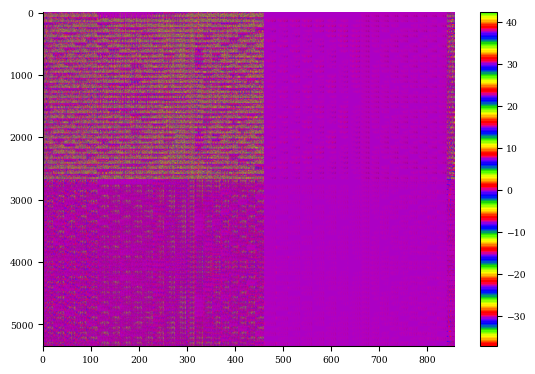

In [32]:
plt.imshow(J, aspect="auto", cmap="prism")
plt.colorbar()
plt.savefig("jacobian.png", dpi=1000)

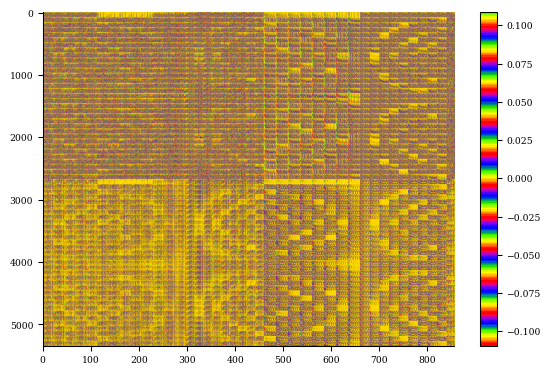

In [33]:
plt.imshow(J*scale, aspect="auto", cmap="prism")
plt.colorbar()
plt.savefig("jacobian_scaled.png", dpi=1000)

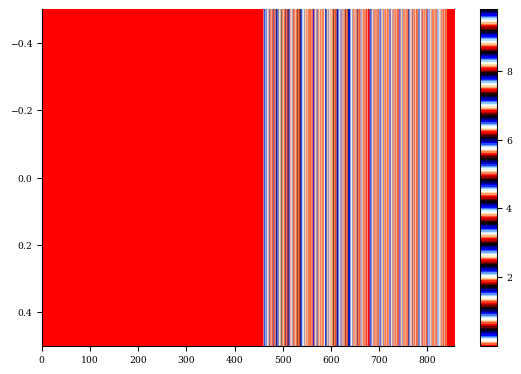

In [28]:
plt.imshow(scale[None, :], aspect="auto", cmap="flag")
plt.colorbar()

Building objective: force
Precomputing transforms


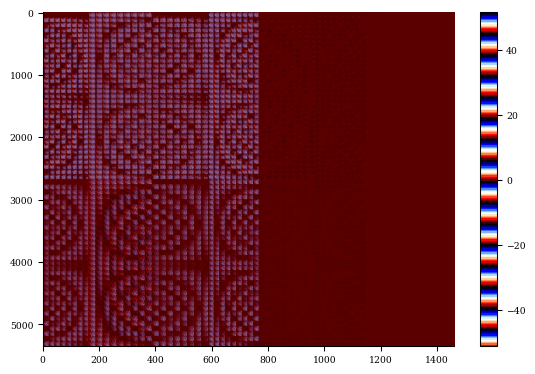

In [30]:
obj1 = ObjectiveFunction(ForceBalance(eq))
obj1.build()
Jobj = obj1.jac_scaled_error(obj1.x(eq))
plt.imshow(Jobj, aspect="auto", cmap="flag")
plt.colorbar()

In [17]:
# grid = ConcentricGrid(
#         L=eq.L_grid,
#         M=eq.M_grid,
#         N=eq.N_grid,
#         NFP=eq.NFP,
#         sym=eq.sym,
#         axis=False,
#     )
# data = eq.compute(["X", "Y", "Z"], grid=grid)
# x = data["X"]
# y = data["Y"]
# z = data["Z"]
# fig = go.Figure()
# plot_3d(eq, "|B|", fig=fig, alpha=0.4)
# fig.add_trace(go.Scatter3d(x=x, 
#                     y=y, 
#                     z=z,
#                     mode='markers', 
#                     marker=dict(   
#                         color='black', 
#                         size=12,    
#                         opacity=1
#                         )
#                     )
#                 )